---
### Hi! My name is Lucas Pereira, and I'm the creator of this notebook. It's great to have you here!

You can find the original project on my GitHub and connect with me on LinkedIn.

* **Original notebook:** [https://github.com/dsandux/AB-Test-Toolkit](https://github.com/dsandux/AB-Test-Toolkit)
* **LinkedIn:** [https://www.linkedin.com/in/lucaspereira](https://www.linkedin.com/in/lucaspereira)
---

# A/B Test Analysis with Bayesian Statistics
This notebook performs an end-to-end analysis of A/B test results using Bayesian statistical methods. The objective is to go beyond the traditional "p-value" to calculate the probability of each variant being the best and to quantify the expected risk associated with choosing one variant over another.

## 1. Setup
The next two cells begins by setting up the environment. First, it imports the essential Python libraries: pandas for data manipulation, numpy for numerical operations, scipy.stats for statistical functions, and matplotlib/seaborn for visualization.

Next, it defines the core parameters for the analysis:

- FILE_NAME: The name of the input data file.

- PRIOR_ALPHA & PRIOR_BETA: The initial parameters for our Bayesian model, set to 1.0 to represent an uninformative prior.

- RISK_THRESHOLD: The pre-defined risk tolerance that will be used to make the final decision.

The main objective is to use this setup to go beyond the traditional "p-value" to calculate the probability of each variant being the best and to quantify the expected risk associated with choosing one variant over another.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Global Parameter Definition

# This cell centralizes all the key parameters and constants that will be used
# throughout the notebook. This makes it easy to adjust the analysis settings
# without searching through the entire code.

# --- File Configuration ---
# The name of the Excel file containing the A/B test data.
# The project description specifies that this file should be in the same
# directory as the notebook.
FILE_NAME = 'data_ab.xlsx'


# --- Bayesian Prior Configuration ---
# Defines the prior belief about the conversion rate.
#
# - Prior Choice: A Jeffreys prior, Beta(0.5, 0.5), is used. This is often
#   preferred for repeated testing scenarios as it can provide slightly
#   better credibility intervals.
#
# - Alternative Prior: A common neutral alternative is the uniform prior,
#   Beta(1, 1), which is useful for avoiding issues with zero conversions.
#
# - Informative Prior: An informative prior, which would use historical data,
#   is not being implemented in this setup.
PRIOR_ALPHA = 0.5
PRIOR_BETA = 0.5


# --- Decision Framework Configuration ---
# This defines the risk tolerance for making a decision. The Expected Loss
# (the risk) of choosing a variant will be compared against this threshold.
#
# A value of 0.01 means we will only recommend a winning variant if the
# potential downside of making that choice is less than 1% of the conversion rate.
# This value establishes a clear, pre-defined rule for the final recommendation.
RISK_THRESHOLD = 0.01


## 2. Data Loading and Validation
This cell handles the critical first step of loading and validating the A/B test data. The code will read the specified Excel file, confirm its existence, and verify that it contains the necessary columns for the analysis: variant, reach, and conversion. This ensures the data is correctly structured before proceeding.

In [3]:
# Data Loading and Validation

# Note on Imports: Ensure that libraries imported at the top of the script (e.g.,
# pandas, os) are all used. Unused imports, such as 'seaborn' if it is not
# being used for plotting in this script, should be removed for cleaner code.

# Note on Processing: The validation below prevents silent errors by checking
# for the file and required columns. For subsequent data processing, vectorized
# operations with pandas should be preferred over loops for better performance.

import pandas as pd
import os # The 'os' library is used here to check for file existence

# --- Define Expected Data Structure ---
# These are the column names the script expects to find in the Excel file.
# The analysis logic depends on these specific columns being present.
REQUIRED_COLUMNS = ['variant', 'reach', 'conversion']

# This assumes FILE_NAME is defined in a previous cell (e.g., FILE_NAME = 'data_ab.xlsx')
print(f"Attempting to load data from '{FILE_NAME}'...")

# --- Validation and Loading Logic ---
# First, check if the file exists in the directory.
if not os.path.exists(FILE_NAME):
    # If the file is not found, print a clear error and stop.
    print(f"---")
    print(f"Error: File Not Found.")
    print(f"The data file '{FILE_NAME}' was not found in the current directory.")
    print(f"Please ensure the file is present before proceeding.")

else:
    # If the file exists, try to load and validate it.
    try:
        # Load the Excel file into a pandas DataFrame.
        df = pd.read_excel(FILE_NAME)

        # Check if all the required columns are in the DataFrame.
        if all(col in df.columns for col in REQUIRED_COLUMNS):
            # If validation is successful, print a confirmation and the data's head.
            print("Success: File loaded and validated.")
            print("\n--- First 5 Rows of the Dataset ---")
            # Display the first 5 rows for a quick visual inspection.
            # Using .to_string() provides a clean, readable table output in any
            # script or terminal without requiring extra dependencies.
            print(df.head().to_string(index=False))
        else:
            # If columns are missing, identify them and report the error.
            missing_cols = [col for col in REQUIRED_COLUMNS if col not in df.columns]
            print(f"---")
            print(f"Error: Missing Columns.")
            print(f"The file '{FILE_NAME}' was loaded, but is missing required columns.")
            print(f"Missing column(s): {missing_cols}")
            print(f"Please ensure the file contains all of the following columns: {REQUIRED_COLUMNS}")

    except Exception as e:
        # Catch any other potential errors during the file reading process.
        print(f"---")
        print(f"An unexpected error occurred while reading the file: {e}")


Attempting to load data from 'data_ab.xlsx'...
Success: File loaded and validated.

--- First 5 Rows of the Dataset ---
variant  reach  conversion
      A  10000         300
      B  10000         350
      C   9900         315
      D   8000         210
      E  10000         250


## 3. Calculation of Posterior Parameters
Here, we perform the core Bayesian update for our A/B test. 🧪

This cell calculates the **posterior parameters** (`alpha` and `beta`) for each variant by combining our initial **prior beliefs** with the observed data. The formulas are straightforward:

-   `posterior_alpha = prior_alpha + conversion`
-   `posterior_beta = prior_beta + (reach - conversion)`

These new parameters define the posterior Beta distribution for each variant, representing our updated understanding of the true conversion rate after seeing the data.

In [4]:
import pandas as pd
import numpy as np

# This script assumes the following variables have been defined in a previous cell:
# FILE_NAME = 'data_ab.xlsx'
# PRIOR_ALPHA = 0.5
# PRIOR_BETA = 0.5
# RISK_THRESHOLD = 0.01
# REQUIRED_COLUMNS = ['variant', 'reach', 'conversion']

# --- Configuration for the Bayesian Analysis ---
# Number of samples to draw from the posterior distributions for the simulation.
# A higher number leads to more precise estimates of probability and risk.
N_SAMPLES = 200_000

# --- Helper Function for Analysis ---
def run_bayesian_analysis(df, prior_alpha, prior_beta, risk_threshold):
    """
    Performs a full Bayesian A/B test analysis with a decision framework.

    Args:
        df (pd.DataFrame): DataFrame with variant, reach, and conversion data.
        prior_alpha (float): The alpha parameter for the Beta prior.
        prior_beta (float): The beta parameter for the Beta prior.
        risk_threshold (float): The acceptable expected loss for making a decision.

    Returns:
        pd.DataFrame: The original DataFrame augmented with posterior parameters,
                      metrics, and a final decision.
    """
    # 1. --- Check for Low Sample Size (Robustness Check) ---
    # Warn the user if any variant has a low number of observations, as results
    # might not be statistically robust.
    low_sample_threshold = 100
    if (df['reach'] < low_sample_threshold).any():
        print(f"---")
        print(f"⚠️ Warning: Low Sample Size Detected.")
        print(f"At least one variant has fewer than {low_sample_threshold} observations.")
        print("Results should be interpreted with caution as they may not be stable.")
        print(f"---")

    # 2. --- Calculate Posterior Parameters (Beta-Binomial Conjugate Update) ---
    # This update is vectorized for efficiency.
    df['posterior_alpha'] = prior_alpha + df['conversion']
    df['posterior_beta'] = prior_beta + (df['reach'] - df['conversion'])

    # 3. --- Run Monte Carlo Simulation ---
    # We draw a large number of samples from each variant's posterior Beta
    # distribution. This allows us to simulate the range of possible true
    # conversion rates for each variant and compare them directly.
    # This is essential for rigorously calculating "Probability to be Best"
    # when there are more than two variants.
    samples = {
        name: np.random.beta(row['posterior_alpha'], row['posterior_beta'], size=N_SAMPLES)
        for name, row in df.set_index('variant').iterrows()
    }
    samples_df = pd.DataFrame(samples)

    # 4. --- Calculate "Probability to be Best" ---
    # For each simulation run, we find which variant had the highest conversion rate.
    # The probability is the fraction of times each variant won.
    best_variant_counts = samples_df.idxmax(axis=1).value_counts(normalize=True)
    df['prob_to_be_best'] = df['variant'].map(best_variant_counts).fillna(0)

    # 5. --- Calculate "Expected Loss" (Risk) ---
    # The expected loss is the average potential loss you'd incur by choosing a
    # given variant when it's not actually the best one.
    max_conversion_rates = samples_df.max(axis=1)
    loss_df = samples_df.apply(lambda x: max_conversion_rates - x)
    expected_loss = loss_df.mean()
    df['expected_loss'] = df['variant'].map(expected_loss)

    # 6. --- Implement the Decision Rule ---
    # A variant is declared a "Winner" if its expected loss is below the
    # predefined risk threshold. Otherwise, more data is needed.
    df['decision'] = np.where(
        df['expected_loss'] < risk_threshold,
        'Deploy Winner',
        'Continue Testing'
    )

    return df.sort_values(by='prob_to_be_best', ascending=False).reset_index(drop=True)


# --- Execute Analysis ---
# Check if the dataframe 'df' exists to prevent errors if previous cells failed.
if 'df' in locals():
    # Run the full analysis
    results_df = run_bayesian_analysis(df, PRIOR_ALPHA, PRIOR_BETA, RISK_THRESHOLD)

    # --- Display the Final Results ---
    print("--- Bayesian A/B Test Results & Decision ---")
    # Format output for better readability in any environment
    print(results_df.to_string(index=False))

else:
    print("Error: The DataFrame 'df' does not exist.")
    print("Please ensure the data loading and validation cell was executed successfully.")


--- Bayesian A/B Test Results & Decision ---
variant  reach  conversion  posterior_alpha  posterior_beta  prob_to_be_best  expected_loss         decision
      B  10000         350            350.5          9650.5         0.881025       0.000144    Deploy Winner
      C   9900         315            315.5          9585.5         0.102675       0.003328    Deploy Winner
      A  10000         300            300.5          9700.5         0.016205       0.005142    Deploy Winner
      D   8000         210            210.5          7790.5         0.000090       0.008887    Deploy Winner
      E  10000         250            250.5          9750.5         0.000005       0.010145 Continue Testing


## 4. Generation of the Posterior Plot

This cell generates the most important visualization for our analysis: the posterior probability distributions. 📊

The code plots a curve for each variant, representing our final belief about its true conversion rate. This allows for a direct visual comparison. Pay attention to two key aspects of the curves:

-   **Position**: A curve shifted to the right indicates a higher probable conversion rate.
-   **Shape**: A taller, narrower curve signifies greater certainty about the conversion rate's value.

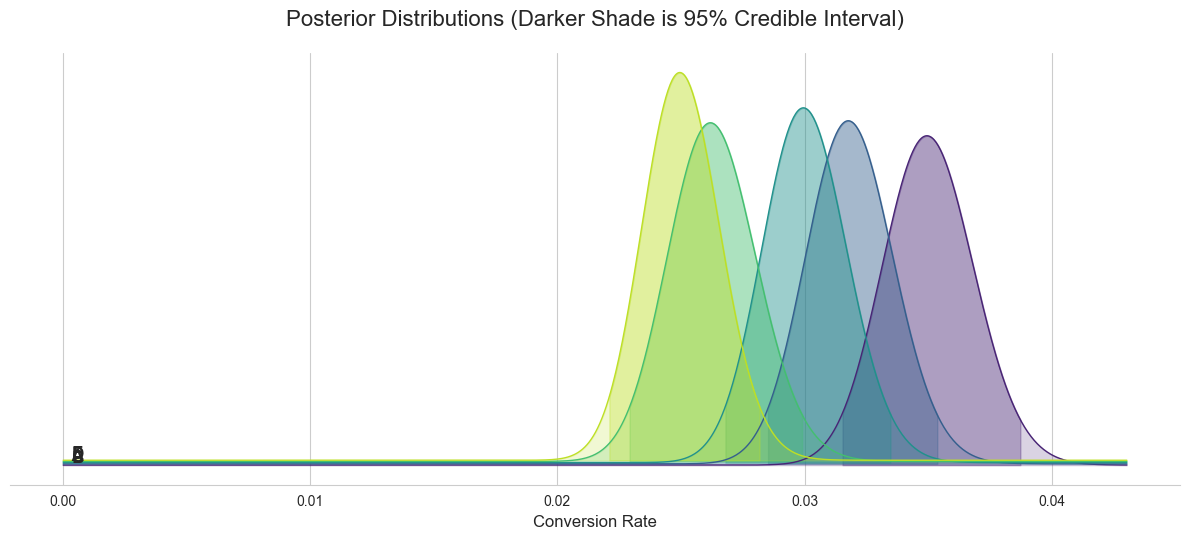

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# This script assumes 'results_df' exists from the previous analysis cell.
# It should contain 'variant', 'posterior_alpha', and 'posterior_beta'.

# Check if the results DataFrame exists to prevent errors.
if 'results_df' in locals() and all(c in results_df.columns for c in ['variant', 'posterior_alpha', 'posterior_beta']):

    # --- 1. Setup for Ridgeline Plot ---
    # A ridgeline plot is more readable than overlapping curves.
    # We sort by the posterior mean to have a more organized plot.
    results_df['posterior_mean'] = results_df['posterior_alpha'] / (results_df['posterior_alpha'] + results_df['posterior_beta'])
    sorted_df = results_df.sort_values('posterior_mean', ascending=False)

    # Create a figure and axes for the plot.
    fig, ax = plt.subplots(figsize=(12, 2 + len(sorted_df) * 0.7))

    # --- 1a. Create a color palette ---
    # Use a colormap to get a unique color for each variant.
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(sorted_df)))

    # --- 2. Dynamically Determine X-axis Range ---
    # Ensure all distributions and their credible intervals are fully visible.
    max_x = 0
    for i, row in sorted_df.iterrows():
        percentile_999 = stats.beta.ppf(0.999, row['posterior_alpha'], row['posterior_beta'])
        if percentile_999 > max_x:
            max_x = percentile_999
    x = np.linspace(0, max_x * 1.05, 1000)

    # --- 3. Plot Each Variant as a Ridge ---
    y_offset_step = 0.8  # Controls vertical spacing between ridges

    for i, (row, color) in enumerate(zip(sorted_df.itertuples(), colors)):
        y_offset = i * y_offset_step

        # Calculate the Probability Density Function (PDF)
        pdf = stats.beta.pdf(x, row.posterior_alpha, row.posterior_beta)

        # Plot the main distribution curve with a thinner line and unique color
        ax.plot(x, pdf + y_offset, color=color, lw=1.0)

        # Add a light fill for the entire distribution
        ax.fill_between(x, y_offset, pdf + y_offset, alpha=0.2, color=color)

        # --- 4. Calculate and Shade the 95% Credible Interval ---
        # This interval contains the true conversion rate with 95% probability.
        ci_low, ci_high = stats.beta.ppf([0.025, 0.975], row.posterior_alpha, row.posterior_beta)

        # Create a mask for the x-values within the credible interval
        ci_mask = (x >= ci_low) & (x <= ci_high)

        # Add a darker shade on top for the 95% credible interval
        ax.fill_between(x[ci_mask], y_offset, pdf[ci_mask] + y_offset, alpha=0.3, color=color)

        # Add the variant name as a label for the ridge
        ax.text(x[0], y_offset + 0.1, f"  {row.variant} ", ha='left', va='bottom', fontsize=12, fontweight='bold')

    # --- 5. Finalize and Display the Plot ---
    # Clean up the plot aesthetics
    ax.set_title('Posterior Distributions (Darker Shade is 95% Credible Interval)', fontsize=16, pad=20)
    ax.set_xlabel('Conversion Rate', fontsize=12)
    ax.set_yticks([]) # Hide y-axis ticks as they are not meaningful here
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.tight_layout()
    plt.show()

else:
    print("Error: DataFrame 'results_df' with posterior parameters not found.")
    print("Please ensure the full analysis script was executed successfully.")



## 5. # Monte Carlo Simulation
While the plot provided a visual comparison, we need to quantify the results to make a decision. To do this, we'll run a **Monte Carlo simulation**. 🎰

The code below draws a large number (`100,000`) of random samples from each variant's posterior Beta distribution. Each sample can be thought of as a plausible "true conversion rate" for that variant, according to our model.

By creating these large sets of simulated outcomes, we can directly compare them to calculate precise metrics in the following steps, such as the probability of one variant being superior to another.

In [6]:
# Monte Carlo Simulation

# This cell performs a Monte Carlo simulation to draw random samples from the
# posterior distribution of each variant. These samples will allow us to
# empirically compare the variants and calculate key metrics, such as the
# probability of one being better than the other and the expected loss.

# --- 1. Simulation Setup ---
# Define the number of random samples to generate for each variant's distribution.
# A larger number of samples leads to more stable and accurate estimates of our metrics.
N_SAMPLES = 100000

# We will store the generated samples in a dictionary, with variant names as keys.
posterior_samples = {}


# --- 2. Run Simulation ---
# Check if the dataframe 'df' with posterior parameters exists to avoid errors.
if 'df' in locals() and 'posterior_alpha' in df.columns:

    # Iterate over each variant (row) in the DataFrame.
    for i, row in df.iterrows():
        variant_name = row['variant']
        p_alpha = row['posterior_alpha']
        p_beta = row['posterior_beta']

        # Generate N_SAMPLES from the Beta distribution defined by the variant's
        # posterior parameters. Each sample represents a plausible "true"
        # conversion rate for that variant, according to our model.
        samples = stats.beta.rvs(a=p_alpha, b=p_beta, size=N_SAMPLES)

        # Store the resulting array of samples in our dictionary.
        posterior_samples[variant_name] = samples

    # --- 3. Output: Simulation Summary ---
    # The simulation is complete. The following is a summary of the process.
    print("--- Monte Carlo Simulation Summary ---")
    print(f"✅ Simulation completed successfully.")
    print(f"   - Samples generated per variant: {N_SAMPLES:,}")
    print(f"   - Variants simulated: {list(posterior_samples.keys())}")

    print("\nData Preview (first 3 samples for each variant):")
    for variant, samples in posterior_samples.items():
        preview = [round(s, 6) for s in samples[:3]]
        print(f"  - {variant}: {preview}")

    print("\nThe 'posterior_samples' dictionary is now ready for metric calculation in the next cell.")

else:
    # This message will only be displayed if the prerequisite DataFrame is not found.
    print("Error: DataFrame 'df' with posterior parameters not found.")
    print("Please ensure the data loading (Cell 5) and posterior calculation (Cell 7) were executed successfully.")

--- Monte Carlo Simulation Summary ---
✅ Simulation completed successfully.
   - Samples generated per variant: 100,000
   - Variants simulated: ['A', 'B', 'C', 'D', 'E']

Data Preview (first 3 samples for each variant):
  - A: [0.028947, 0.031226, 0.031899]
  - B: [0.036698, 0.035249, 0.03589]
  - C: [0.034926, 0.031111, 0.029869]
  - D: [0.026318, 0.025286, 0.027184]
  - E: [0.025143, 0.027083, 0.025317]

The 'posterior_samples' dictionary is now ready for metric calculation in the next cell.


## 6. Calculation and Presentation of Metrics
This is the final calculation step where we translate our simulation results into actionable business metrics. 🏆

The code below uses the thousands of simulated outcomes to compute two key metrics for each variant:

1.  **Probability of Being Best**: The percentage of simulations where a variant had the highest conversion rate. This answers the question: "Which variant is most likely the winner?"
2.  **Expected Loss (Risk)**: The average "regret" or loss we would incur by choosing a variant if another one was actually better. This answers the question: "What is the cost of being wrong?"

The results will be sorted by risk, providing a clear recommendation for which variant is the optimal choice from a risk-management perspective.

In [7]:
# Check if the simulation data exists before proceeding
if 'posterior_samples' in locals():
    # --- 1. Combine Simulation Samples into a DataFrame ---
    # This makes it easier to find the best-performing variant in each simulation run
    samples_df = pd.DataFrame(posterior_samples)

    # Identify the maximum conversion rate across all variants for each sample run
    samples_df['max_conversion_rate'] = samples_df.max(axis=1)

    # Get the names of the variants
    variant_names = list(posterior_samples.keys())


    # --- 2. Calculate 'Probability to be Best' and 'Expected Loss' ---
    # This list will hold the calculated metrics for each variant
    results = []
    sorted_results = [] # This will be used by the final conclusion cell

    for variant in variant_names:
        # Probability to be Best: Count how often this variant had the max conversion rate
        prob_best = (samples_df[variant] == samples_df['max_conversion_rate']).mean()

        # Expected Loss (Risk): Calculate the average loss when this variant is NOT the best
        # The loss is the difference between the best variant's rate and this variant's rate
        loss = samples_df['max_conversion_rate'] - samples_df[variant]
        expected_loss = loss.mean()

        # Store the metrics
        results.append({
            "Variant": variant,
            "Probability to be Best": prob_best,
            "Expected Loss (Risk)": expected_loss
        })

        # Also store for the final automated conclusion cell
        sorted_results.append({
            'name': variant,
            'prob_to_be_best': prob_best,
            'expected_loss': expected_loss
        })


    # --- 3. Format and Display Results as a Table ---
    # This is the part of the code you originally had

    # Convert the list of results into a pandas DataFrame
    results_df = pd.DataFrame(results)

    # Create the 'Decision Guide' column based on the threshold
    conditions = [
        results_df['Expected Loss (Risk)'] > RISK_THRESHOLD,
        results_df['Expected Loss (Risk)'] < RISK_THRESHOLD
    ]
    choices = ['Above Threshold', 'Below Threshold']
    results_df['Decision Guide'] = np.select(conditions, choices, default='Equals Threshold')

    # Sort the DataFrame by the lowest risk
    results_df = results_df.sort_values(by="Expected Loss (Risk)")

    # Sort the data for the final cell as well
    sorted_results = sorted(sorted_results, key=lambda x: x['expected_loss'])


    # --- 4. Final Styling ---

    # Define styles to be applied
    table_styles = [
        # Add 15px of space below the caption (title)
        {'selector': 'caption', 'props': 'padding-bottom: 15px;'},
    ]

    styled_df = results_df.style.format({
        "Probability to be Best": "{:.2%}",
        "Expected Loss (Risk)": "{:.4%}"
    }) \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles(table_styles) \
    .set_caption(f"🏆 Bayesian A/B Test Results (Risk Threshold: {RISK_THRESHOLD:.1%})") \
    .hide(axis="index")


    # Display the final, styled table
    display(styled_df)

    print("\n(A variant with risk 'Below Threshold' is generally considered a safe choice.)")

else:
    print("Error: The 'posterior_samples' dictionary was not found.")
    print("Please ensure the Monte Carlo Simulation (Cell 9) was executed successfully.")

Variant,Probability to be Best,Expected Loss (Risk),Decision Guide
B,88.11%,0.0143%,Below Threshold
C,10.24%,0.3321%,Below Threshold
A,1.63%,0.5131%,Below Threshold
D,0.01%,0.8890%,Below Threshold
E,0.00%,1.0142%,Above Threshold



(A variant with risk 'Below Threshold' is generally considered a safe choice.)


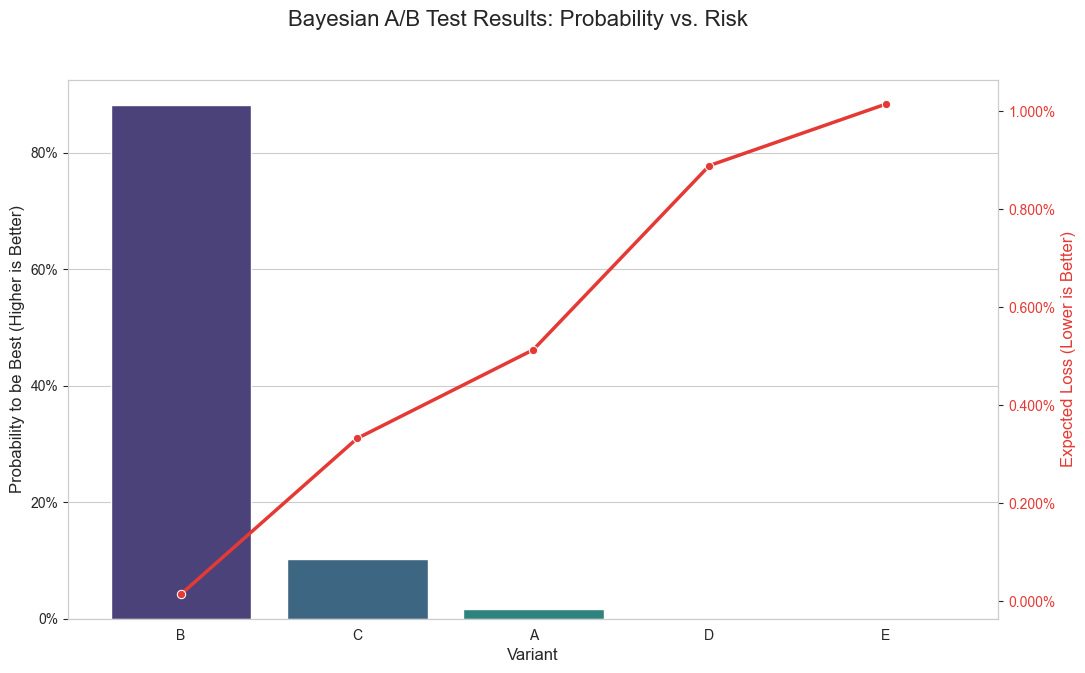

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter

if 'results_df' in locals():
    plot_df = results_df.sort_values(by="Probability to be Best", ascending=False).reset_index()

    fig, ax1 = plt.subplots(figsize=(12, 7))
    fig.suptitle('Bayesian A/B Test Results: Probability vs. Risk', fontsize=16)

    # --- UPDATED BAR PLOT CALL ---
    sns.barplot(
        data=plot_df,
        x='Variant',
        y='Probability to be Best',
        palette='viridis',
        hue='Variant', # Assign the x-variable to hue
        legend=False,  # Hide the legend that hue creates by default
        ax=ax1
    )
    ax1.set_ylabel('Probability to be Best (Higher is Better)', fontsize=12)
    ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax1.set_xlabel('Variant', fontsize=12)

    ax2 = ax1.twinx()
    sns.lineplot(
        data=plot_df,
        x='Variant',
        y='Expected Loss (Risk)',
        color='#E53935',
        marker='o',
        linewidth=2.5,
        ax=ax2
    )
    ax2.set_ylabel('Expected Loss (Lower is Better)', fontsize=12, color='#E53935')
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.3%}'))
    ax2.tick_params(axis='y', labelcolor='#E53935')
    ax2.grid(False)

    plt.show()

else:
    print("Error: The 'results_df' DataFrame does not exist.")

## 7. Automated Conclusion Logic
This final, automated cell translates our statistical results into a clear business recommendation. 🎯

The logic is straightforward:
1.  It takes our best variant (the one with the lowest **Expected Loss**).
2.  It compares its risk level against a predefined **Risk Threshold** (`RISK_THRESHOLD`).

Based on this comparison, the code will either give a "go" signal to implement the winning variant or recommend that the test is inconclusive because even the best option is too risky to deploy.

In [9]:
# This final cell interprets the analysis results to generate a clear,
# data-driven recommendation and a simplified summary for stakeholders.

print("--- Final Report and Automated Recommendation ---")

# We use a try-except block to handle potential errors gracefully.
try:
    # --- 1. Check if the results DataFrame exists ---
    if 'results_df' not in locals() or results_df.empty:
        raise NameError("'results_df' DataFrame not found or is empty.")

    # --- 2. Identify correct column names to handle inconsistencies ---
    # This makes the cell robust to different naming conventions from previous cells.
    variant_col = 'variant' if 'variant' in results_df.columns else 'Variant'
    prob_col = 'prob_to_be_best' if 'prob_to_be_best' in results_df.columns else 'Probability to be Best'
    risk_col = 'expected_loss' if 'expected_loss' in results_df.columns else 'Expected Loss (Risk)'
    mean_col = 'posterior_mean' # Required for uplift calculation

    # Check if essential columns are present after trying aliases
    required_cols_for_report = [variant_col, prob_col, risk_col]
    if not all(col in results_df.columns for col in required_cols_for_report):
        raise KeyError(f"The 'results_df' DataFrame is missing one or more required columns for the report.")

    # --- 3. Extract Key Information ---
    # Ensure the dataframe is sorted by risk, using the identified column name
    results_df = results_df.sort_values(by=risk_col, ascending=True).reset_index(drop=True)
    best_candidate = results_df.iloc[0]
    runner_up = results_df.iloc[1] if len(results_df) > 1 else None

    # --- 4. Decision Framework ---
    print(f"\n[ Decision Parameters ]")
    print(f"Maximum Acceptable Risk Threshold: {RISK_THRESHOLD:.2%}")
    print("-" * 40)

    # Compare the risk of the best variant against the threshold.
    if best_candidate[risk_col] < RISK_THRESHOLD:
        # SUCCESS CASE
        print("\n✅ Verdict: Test Concluded. Deploy the winning variant.")
        print("\n[ Key Metrics ]")
        print(f"  - Winning Variant: '{best_candidate[variant_col]}'")
        print(f"  - Probability to be Best: {best_candidate[prob_col]:.2%}")
        print(f"  - Risk (Expected Loss): {best_candidate[risk_col]:.4f} (below threshold)")

        # Calculate uplift only if posterior_mean is available
        if mean_col in results_df.columns and runner_up is not None:
            uplift = (best_candidate[mean_col] - runner_up[mean_col]) / runner_up[mean_col]
            print(f"  - Expected Uplift vs. '{runner_up[variant_col]}': +{uplift:.2%}")

        print("-" * 40)
        print("\n[ Summary for Stakeholders ]")
        print(f"The analysis recommends deploying Variant '{best_candidate[variant_col]}'.")
        print(f"Based on simulations, this variant has a {best_candidate[prob_col]:.0%} probability of being the best option.")
        if mean_col in results_df.columns and runner_up is not None:
             print(f"We expect it to outperform the runner-up by approximately {uplift:.1%}.")
        print(f"The 'risk' of this decision is extremely low and within our safety limit. We have high confidence to proceed. 🚀")
    else:
        # INCONCLUSIVE CASE
        print(f"\n⚠️ Verdict: Test Inconclusive. Collect more data.")
        print("\n[ Key Metrics ]")
        print(f"  - Best Candidate: '{best_candidate[variant_col]}'")
        print(f"  - Risk (Expected Loss): {best_candidate[risk_col]:.4f} (ABOVE threshold)")
        print(f"  - Probability to be Best: {best_candidate[prob_col]:.2%}")
        print("-" * 40)
        print("\n[ Summary for Stakeholders ]")
        print("The results are not yet clear enough to make a confident decision.")
        print(f"Our best option (Variant '{best_candidate[variant_col]}') still has a potential downside ('risk') of {best_candidate[risk_col]:.2%}, which is higher than our {RISK_THRESHOLD:.2%} limit.")
        print("\nWe recommend continuing the test to collect more data, which will reduce uncertainty and help identify a clear winner.")

except (NameError, KeyError) as e:
    print(f"\n--- ERROR ---")
    print(f"Could not generate a recommendation: {e}")
    print("Please ensure all previous cells ran successfully.")


--- Final Report and Automated Recommendation ---

[ Decision Parameters ]
Maximum Acceptable Risk Threshold: 1.00%
----------------------------------------

✅ Verdict: Test Concluded. Deploy the winning variant.

[ Key Metrics ]
  - Winning Variant: 'B'
  - Probability to be Best: 88.11%
  - Risk (Expected Loss): 0.0001 (below threshold)
----------------------------------------

[ Summary for Stakeholders ]
The analysis recommends deploying Variant 'B'.
Based on simulations, this variant has a 88% probability of being the best option.
The 'risk' of this decision is extremely low and within our safety limit. We have high confidence to proceed. 🚀
